**This is the part of the project where the model is trained (Inversion Rectifier)**

The Data directory should have two subdirectores, 0 and 1, 0 representing images which are upright and 1 the images which are upside down

In [ ]:
!gdown --id "id of google drive with dataset in it"

In [25]:
!unzip -q training_data.zip 

In [3]:
import os
import random

subdir = 'training_data/0'
files = os.listdir(subdir)
random.shuffle(files)

for i, f in enumerate(files):
  os.rename(os.path.join(subdir, f), os.path.join(subdir, str(i) + '.jpg'))


import os
import random

subdir = 'training_data/1'
files = os.listdir(subdir)
random.shuffle(files)

for i, f in enumerate(files):
  os.rename(os.path.join(subdir, f), os.path.join(subdir, str(i) + '.jpg'))

Split the data into Train, Validation and Test Split

In [4]:
%%bash

mkdir /content/DATA/testing_data
mkdir /content/DATA/validation_data

mkdir /content/DATA/testing_data/0
mkdir /content/DATA/testing_data/1

mkdir /content/DATA/validation_data/0
mkdir /content/DATA/validation_data/1

In [5]:
!find /content/DATA/training_data/0 -name "*.jpg" | shuf -n $(expr $(find /content/DATA/training_data/0 -name "*.jpg" | wc -l) \* 15 / 100) | xargs -I{} mv {} /content/DATA/validation_data/0

In [6]:
!find /content/DATA/training_data/1 -name "*.jpg" | shuf -n $(expr $(find /content/DATA/training_data/1 -name "*.jpg" | wc -l) \* 16 / 100) | xargs -I{} mv {} /content/DATA/validation_data/1

In [7]:
!ls /content/DATA/validation_data/0 -l | wc -l
!ls /content/DATA/validation_data/1 -l | wc -l

82
80


In [8]:
!find /content/DATA/training_data/0 -name "*.jpg" | shuf -n $(expr $(find /content/DATA/training_data/0 -name "*.jpg" | wc -l) \* 15 / 100) | xargs -I{} mv {} /content/DATA/testing_data/0

In [ ]:
!find /content/DATA/training_data/1 -name "*.jpg" | shuf -n $(expr $(find /content/DATA/training_data/1 -name "*.jpg" | wc -l) \* 16 / 100) | xargs -I{} mv {} /content/DATA/testing_data/1

In [9]:
!ls /content/DATA/testing_data/0 -l | wc -l
!ls /content/DATA/testing_data/1 -l | wc -l

70
1


In [10]:
!ls /content/DATA/training_data/0 -l | wc -l
!ls /content/DATA/training_data/1 -l | wc -l

397
416


In [11]:
from os import walk
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io
from google.colab.patches import cv2_imshow
import PIL

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(
    rescale=1./255, # Scale the pixel values between 0 and 1
    # rotation_range=40, # Randomly rotate the images by up to 40 degrees
    width_shift_range=0.2, # Randomly shift the images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift the images vertically by up to 20% of the height
    shear_range=0.2, # Randomly apply shearing transformations
    zoom_range=0.2, # Randomly zoom in or out
    # horizontal_flip=True, # Randomly flip the images horizontally
    brightness_range=[0.5, 1.5], # Randomly change the brightness of the image
    channel_shift_range=50, # randomly shift the channels of the image by up to 50
    fill_mode='nearest'
   
)



data_test_gen = ImageDataGenerator(
    rescale=1./255
   
)


# Define the input data pipeline
train = data_gen.flow_from_directory(
    '/content/DATA/training_data', # Path to the image data directory
    target_size=(224, 224), # Resize the images to the specified size
    batch_size=32, # Use a batch size of 32
    class_mode='binary' # Use categorical labels
)

class_freq = data_gen.flow_from_directory(
    '/content/DATA/training_data', # Path to the image data directory
    target_size=(224, 224), # Resize the images to the specified size
    batch_size=32, # Use a batch size of 32
    class_mode='binary' # Use categorical labels
).class_indices

class_weights = {cls: 1.0/freq if freq > 0 else 1.0 for cls, freq in class_freq.items()}





test = data_test_gen.flow_from_directory(
    '/content/DATA/testing_data', # Path to the image data directory
    target_size=(224, 224), # Resize the images to the specified size
    batch_size=138 ,  
    class_mode='binary' # Use categorical labels
)


validation = data_test_gen.flow_from_directory(
    '/content/DATA/validation_data', # Path to the image data directory
    target_size=(224, 224), # Resize the images to the specified size
    batch_size=32, # Use a batch size of 32
    class_mode='binary' # Use categorical labels
)

Found 811 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Found 69 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [13]:
class_freq

{'0': 0, '1': 1}

Create the model


In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Get the number of layers in the base model
# num_layers = len(base_model.layers)
# print(num_layers)
num_layers = 100
# Create a new model using the first half of the layers of the base model
model = Model(inputs=base_model.input, outputs=base_model.layers[num_layers].output)

# Add new layers to the model
x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create a new model with the new layers
model = Model(inputs=model.input, outputs=output)

9406464/9406464 [==============================] - 0s 0us/step


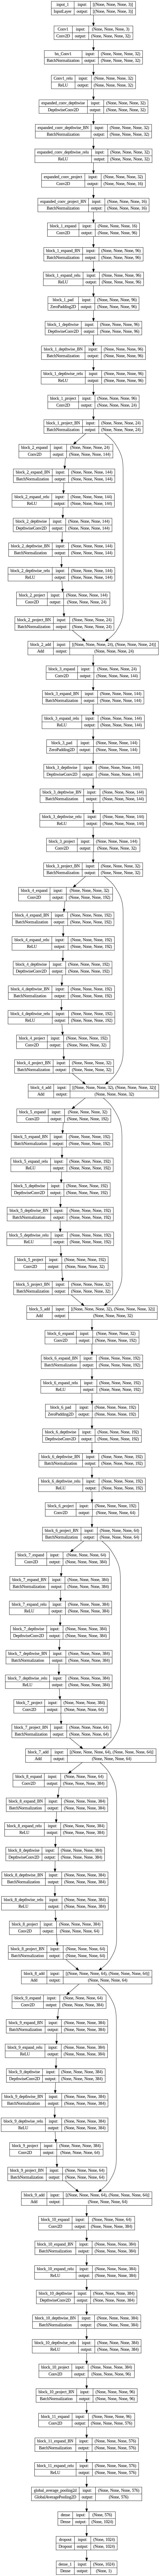

In [15]:
from tensorflow.keras.utils import plot_model

# Assume that 'model' is the instance of your neural network model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


Define Model Checkpoints and a decaying learning rate

In [16]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_acc = ModelCheckpoint(filepath='/content/best_weights_acc'+str(num_layers)+'.h5',
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max')


checkpoint_loss = ModelCheckpoint(filepath='/content/best_weights_loss_'+str(num_layers)+'.h5',
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min')

In [17]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000001)


In [18]:
callback = [checkpoint_acc,checkpoint_loss,reduce_lr]

In [19]:
class_weights

{'0': 1.0, '1': 1.0}

In [ ]:
# Train the model using the data generator 
history = model.fit_generator(train, epochs=120,callbacks=callback,validation_data=validation)

In [ ]:
model.evaluate(test) 

1/1 [==============================] - 10s 10s/step - loss: 0.8277 - accuracy: 0.9111


[0.8276546597480774, 0.9111111164093018]

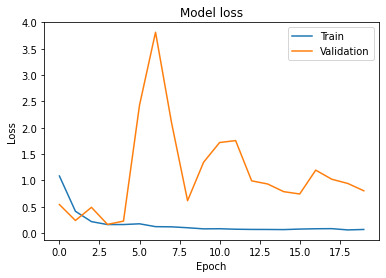

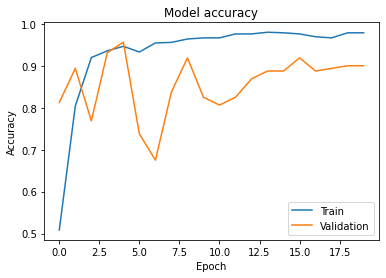

In [ ]:
from matplotlib import pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'])
# Plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training accuracy
plt.plot(history.history['accuracy'])
# Plot the validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Test the best models 

In [ ]:
model.load_weights('/content/best_weights_acc100.h5')
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
"Max Acc accuracy >> ",model.evaluate(test)

1/1 [==============================] - 11s 11s/step - loss: 0.2476 - accuracy: 0.9333


('Max Acc accuracy >> ', [0.24763712286949158, 0.9333333373069763])

In [ ]:
model.load_weights('/content/best_weights_loss_100.h5')
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
"min loss Acc  >> ",model.evaluate(test)

1/1 [==============================] - 11s 11s/step - loss: 0.1571 - accuracy: 0.9407


('min loss Acc  >> ', [0.15712560713291168, 0.9407407641410828])

Save the model architecture


In [ ]:
import json
model_json = model.to_json()

with open("model.json", "w") as f:
    f.write(json.dumps(json.loads(model_json), indent=4))

In [ ]:
model.load_weights('/content/best_weights_with_validation_big_dataset100_acc_100.h5')

In [ ]:
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.evaluate(test)